## Synthetizer of information 

### This is a tool that can create learning material and a guide to help anyone to start to learn any topic

In [6]:
import os
import json
import requests
import asyncio
from dotenv import load_dotenv
from IPython.display import Markdown, display, update_display
from scraper import fetch_website_links, fetch_website_contents
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
from playwright_stealth import Stealth
from openai import OpenAI

In [7]:
load_dotenv(override=True)
api_key_llm = os.getenv('OPENAI_API_KEY')
api_key_search = os.getenv("GOOGLE_SEARCH_API_KEY")
search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")
openai = OpenAI()
MODEL = 'gpt-5-nano'

In [8]:
def google_search(query, api_key, search_engine_id, num_results=10):
    """
    Perform a Google Programmable Search query
    
    query: Search query string
    api_key: Google API key
    search_engine_id: Programmable Search Engine ID (cx)
    num_results: Number of results to fetch (max 10 per API call)
    """

    url = "https://www.googleapis.com/customsearch/v1"

    params = {
        "q": query,
        "key": api_key,
        "cx": search_engine_id,
        "num": num_results
    }

    response = requests.get(url, params=params)
    data = response.json()
    return data

In [9]:
query = "how to build simple AI agent with python"
search_results = {}
search_results = google_search(
    query=query,
    api_key=api_key_search,
    search_engine_id=search_engine_id
    )

In [15]:
search_results['items'][3]['link']

'https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25'

In [16]:
for url in search_results['items']:
    print(url['link'])

https://www.youtube.com/watch?v=bTMPwUgLZf0
https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/
https://www.youtube.com/watch?v=bZzyPscbtI8
https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25
https://www.youtube.com/watch?v=gaGaPpnexxA
https://medium.com/@jagadeesan.ganesh/mastering-llm-ai-agents-building-and-using-ai-agents-in-python-with-real-world-use-cases-c578eb640e35
https://learnwithhasan.com/blog/create-ai-agents-with-python/
https://medium.com/@gurpartap.sandhu3/build-you-own-ai-agent-from-scratch-in-30-mins-using-simple-python-1458f8099da0
https://www.leoniemonigatti.com/blog/ai-agent-from-scratch-in-python.html
https://www.linkedin.com/pulse/how-i-built-my-first-ai-agent-using-python-vivek-kumar-gupta-pr8rc


In [13]:
# I can call an LLM and ask it to pick the most relevant search results in terms of what I want the LLM to do

In [17]:
link_system_prompt = """
You are provided with a list of 10 search results in a form of title and url links. The list will be provided in this format:
{
    "results": [
        {"title_1": "title", "link_1": "url"}, 
        {"title_2": "title", "link_2": "url"}
    ]
}
You are able to decide based on the title and the link which of the links would be most relevant for a research that will follow. This research is aiming
to create a brief study material for beginners.
The goal is to create study material which will help beginners to start learning and help them and motivate them to continue
studying in the first crucial weeks. 
You should respond in JSON as in this example:

{
    "links": [
        {"url": "https://full.url/goes/here/"},
        {"url": "https://another.full.url/"}
    ]
}
"""


In [18]:
# I want to construct the list of links for the user prompt
# {"results": [
# {"title": title, "link": url},
# ]}

def get_search_evaluation_links(search):
    results_for_llm = {"results": []}
    info_block = {}

    for i, link in enumerate(search['items']):
        info_block["title_" + str(i+1)] = link['title']
        info_block["link_" + str(i+1)] = link['link']
        results_for_llm["results"].append(info_block)
        info_block = {}
    return results_for_llm

In [19]:
get_search_evaluation_links(search_results)

{'results': [{'title_1': 'Build an AI Agent From Scratch in Python - Tutorial for Beginners ...',
   'link_1': 'https://www.youtube.com/watch?v=bTMPwUgLZf0'},
  {'title_2': 'My guide on what tools to use to build AI agents (if you are a newb ...',
   'link_2': 'https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/'},
  {'title_3': 'Building AI Agents in Pure Python - Beginner Course - YouTube',
   'link_3': 'https://www.youtube.com/watch?v=bZzyPscbtI8'},
  {'title_4': 'Building a Simple AI Agent With Python and Langchain | by David ...',
   'link_4': 'https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25'},
  {'title_5': 'Build a Python AI Agent in 10 Minutes - YouTube',
   'link_5': 'https://www.youtube.com/watch?v=gaGaPpnexxA'},
  {'title_6': 'Mastering LLM AI Agents: Building and Using AI Agents in Python ...',
   'link_6': 'https://medium.com/@jagadeesan.ganesh/mastering-llm-ai-agents-building-and-using-ai-agents-in

In [24]:
def get_user_prompt():
    search_results = google_search(query, api_key_search, search_engine_id, num_results=10)
    links_for_llm = get_search_evaluation_links(search_results)
    user_prompt = f"""
    Here is the list of titles and links that resulted from the web search:
    {links_for_llm}
    Please decide which of these are the most relevant web links that could be further examined to create
    a brief study material for beginners in this topic:
    {query}.
    Please do not include youtube videos links.
    The goal is to create a brief study material which will help beginners to start learning and help them and motivate them to continue
    studying in the first crucial weeks.
    """
    return user_prompt


    

In [25]:
prompt = get_user_prompt()
print(prompt)


    Here is the list of titles and links that resulted from the web search:
    {'results': [{'title_1': 'Build an AI Agent From Scratch in Python - Tutorial for Beginners ...', 'link_1': 'https://www.youtube.com/watch?v=bTMPwUgLZf0'}, {'title_2': 'My guide on what tools to use to build AI agents (if you are a newb ...', 'link_2': 'https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/'}, {'title_3': 'Building AI Agents in Pure Python - Beginner Course - YouTube', 'link_3': 'https://www.youtube.com/watch?v=bZzyPscbtI8'}, {'title_4': 'Building a Simple AI Agent With Python and Langchain | by David ...', 'link_4': 'https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25'}, {'title_5': 'Build a Python AI Agent in 10 Minutes - YouTube', 'link_5': 'https://www.youtube.com/watch?v=gaGaPpnexxA'}, {'title_6': 'Mastering LLM AI Agents: Building and Using AI Agents in Python ...', 'link_6': 'https://medium.com/@jagadeesan.ganesh/ma

In [26]:
messages=[
            {"role": "system", "content": link_system_prompt},
            {"role": "user", "content": get_user_prompt()}
        ]

In [27]:
def select_relevant_links():
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": link_system_prompt},
            {"role": "user", "content": get_user_prompt()}
        ],
        response_format={"type": "json_object"}
    )
    result = response.choices[0].message.content
    # json.loads turns JSON formatted text into python dictionaries
    links = json.loads(result)
    return links

In [28]:
select_relevant_links()

{'links': [{'url': 'https://learnwithhasan.com/blog/create-ai-agents-with-python/'},
  {'url': 'https://www.leoniemonigatti.com/blog/ai-agent-from-scratch-in-python.html'},
  {'url': 'https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25'},
  {'url': 'https://medium.com/@gurpartap.sandhu3/build-you-own-ai-agent-from-scratch-in-30-mins-using-simple-python-1458f8099da0'},
  {'url': 'https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/'},
  {'url': 'https://www.linkedin.com/pulse/how-i-built-my-first-ai-agent-using-python-vivek-kumar-gupta-pr8rc'}]}

In [33]:
async def scrape_site(url):
    # initialize Stealth with Playwright
    async with Stealth().use_async(async_playwright()) as p:

        # launch headless browser
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url, wait_until="networkidle")

        title = await page.title()

        # Extract data from the page
        text = await page.content()

        await browser.close()

        soup = BeautifulSoup(text, 'html.parser')
        for irrelevant in soup(["script", "style", "img", "input"]):
            irrelevant.decompose()
        text = soup.get_text(separator="\n", strip=True)

        return (title + "\n\n" + text[:200])

In [29]:
relevant_links = {'links': [{'url': 'https://learnwithhasan.com/blog/create-ai-agents-with-python/'},
  {'url': 'https://www.leoniemonigatti.com/blog/ai-agent-from-scratch-in-python.html'},
  {'url': 'https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25'},
  {'url': 'https://medium.com/@gurpartap.sandhu3/build-you-own-ai-agent-from-scratch-in-30-mins-using-simple-python-1458f8099da0'},
  {'url': 'https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/'},
  {'url': 'https://www.linkedin.com/pulse/how-i-built-my-first-ai-agent-using-python-vivek-kumar-gupta-pr8rc'}]}

In [30]:
relevant_links['links'][0]['url']

'https://learnwithhasan.com/blog/create-ai-agents-with-python/'

In [31]:
urls = []
for link in relevant_links['links']:
    print(link['url'])
    urls.append(link['url'])

https://learnwithhasan.com/blog/create-ai-agents-with-python/
https://www.leoniemonigatti.com/blog/ai-agent-from-scratch-in-python.html
https://medium.com/@dvasquez.422/building-a-simple-ai-agent-1e2f2b369b25
https://medium.com/@gurpartap.sandhu3/build-you-own-ai-agent-from-scratch-in-30-mins-using-simple-python-1458f8099da0
https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/
https://www.linkedin.com/pulse/how-i-built-my-first-ai-agent-using-python-vivek-kumar-gupta-pr8rc


In [34]:
await scrape_site(urls[0])

'How To Create AI Agents With Python From Scratch (Full Guide) - LearnWithHasan\n\nHow To Create AI Agents With Python From Scratch (Full Guide) - LearnWithHasan\nWe’ve paused new premium sign-ups to focus on our current members. Free accounts are still open — join the waiting list:\n'

In [119]:
await scrape_site('https://www.reddit.com/r/AI_Agents/comments/1il8b1i/my_guide_on_what_tools_to_use_to_build_ai_agents/')

'Reddit - Prove your humanity\n\nReddit - Prove your humanity\nProve your humanity\nWe’re committed to safety and security. But not for bots. Complete the challenge below and let us know you’re\n          a real person.\nReddit, Inc. © "'

In [ ]:
# How to scrape multiple sites

# This function scrapes one page
async def fetch_title(page, url):
    await page.goto(url, wait_until="networkidle")
    title = await page.title()
    text = await page.content()
    return url, title, text


async def scrape_multiple_sites(urls):
    # initialize Stealth with Playwright
    async with Stealth().use_async(async_playwright()) as p:

        # launch headless browser
        browser = await p.chromium.launch(headless=True)

        tasks = []

        for url in urls:
            page = await browser.new_page()
            # schedule an async scraping job for each page
            tasks.append(fetch_title(page, url))

        # Run all scraping tasks concurrently
        results = await asyncio.gather(*tasks)

        await browser.close()
     
        return results

In [35]:
scrape_results = await scrape_multiple_sites(urls)

[('https://learnwithhasan.com/blog/create-ai-agents-with-python/',
  'How To Create AI Agents With Python From Scratch (Full Guide) - LearnWithHasan',
  '<!DOCTYPE html><html lang="en-US" prefix="og: https://ogp.me/ns#"><head><meta http-equiv="origin-trial" content="A7vZI3v+Gz7JfuRolKNM4Aff6zaGuT7X0mf3wtoZTnKv6497cVMnhy03KDqX7kBz/q/iidW7srW31oQbBt4VhgoAAACUeyJvcmlnaW4iOiJodHRwczovL3d3dy5nb29nbGUuY29tOjQ0MyIsImZlYXR1cmUiOiJEaXNhYmxlVGhpcmRQYXJ0eVN0b3JhZ2VQYXJ0aXRpb25pbmczIiwiZXhwaXJ5IjoxNzU3OTgwODAwLCJpc1N1YmRvbWFpbiI6dHJ1ZSwiaXNUaGlyZFBhcnR5Ijp0cnVlfQ==">\n\t\t<meta charset="UTF-8">\n\t\t<link rel="profile" href="https://gmpg.org/xfn/11">\n\t\t<script type="text/javascript" async="" charset="utf-8" src="https://www.gstatic.com/recaptcha/releases/TkacYOdEJbdB_JjX802TMer9/recaptcha__en.js" crossorigin="anonymous" integrity="sha384-Ft89l3aihBBhSrkZ/Syx/7cCCaryQcJICINmdoWVHhaQefSnqabq/akNl06biiHi"></script><script type="text/html" id="tmpl-bb-link-preview">\n<% if ( link_scrapping ) { %>\n
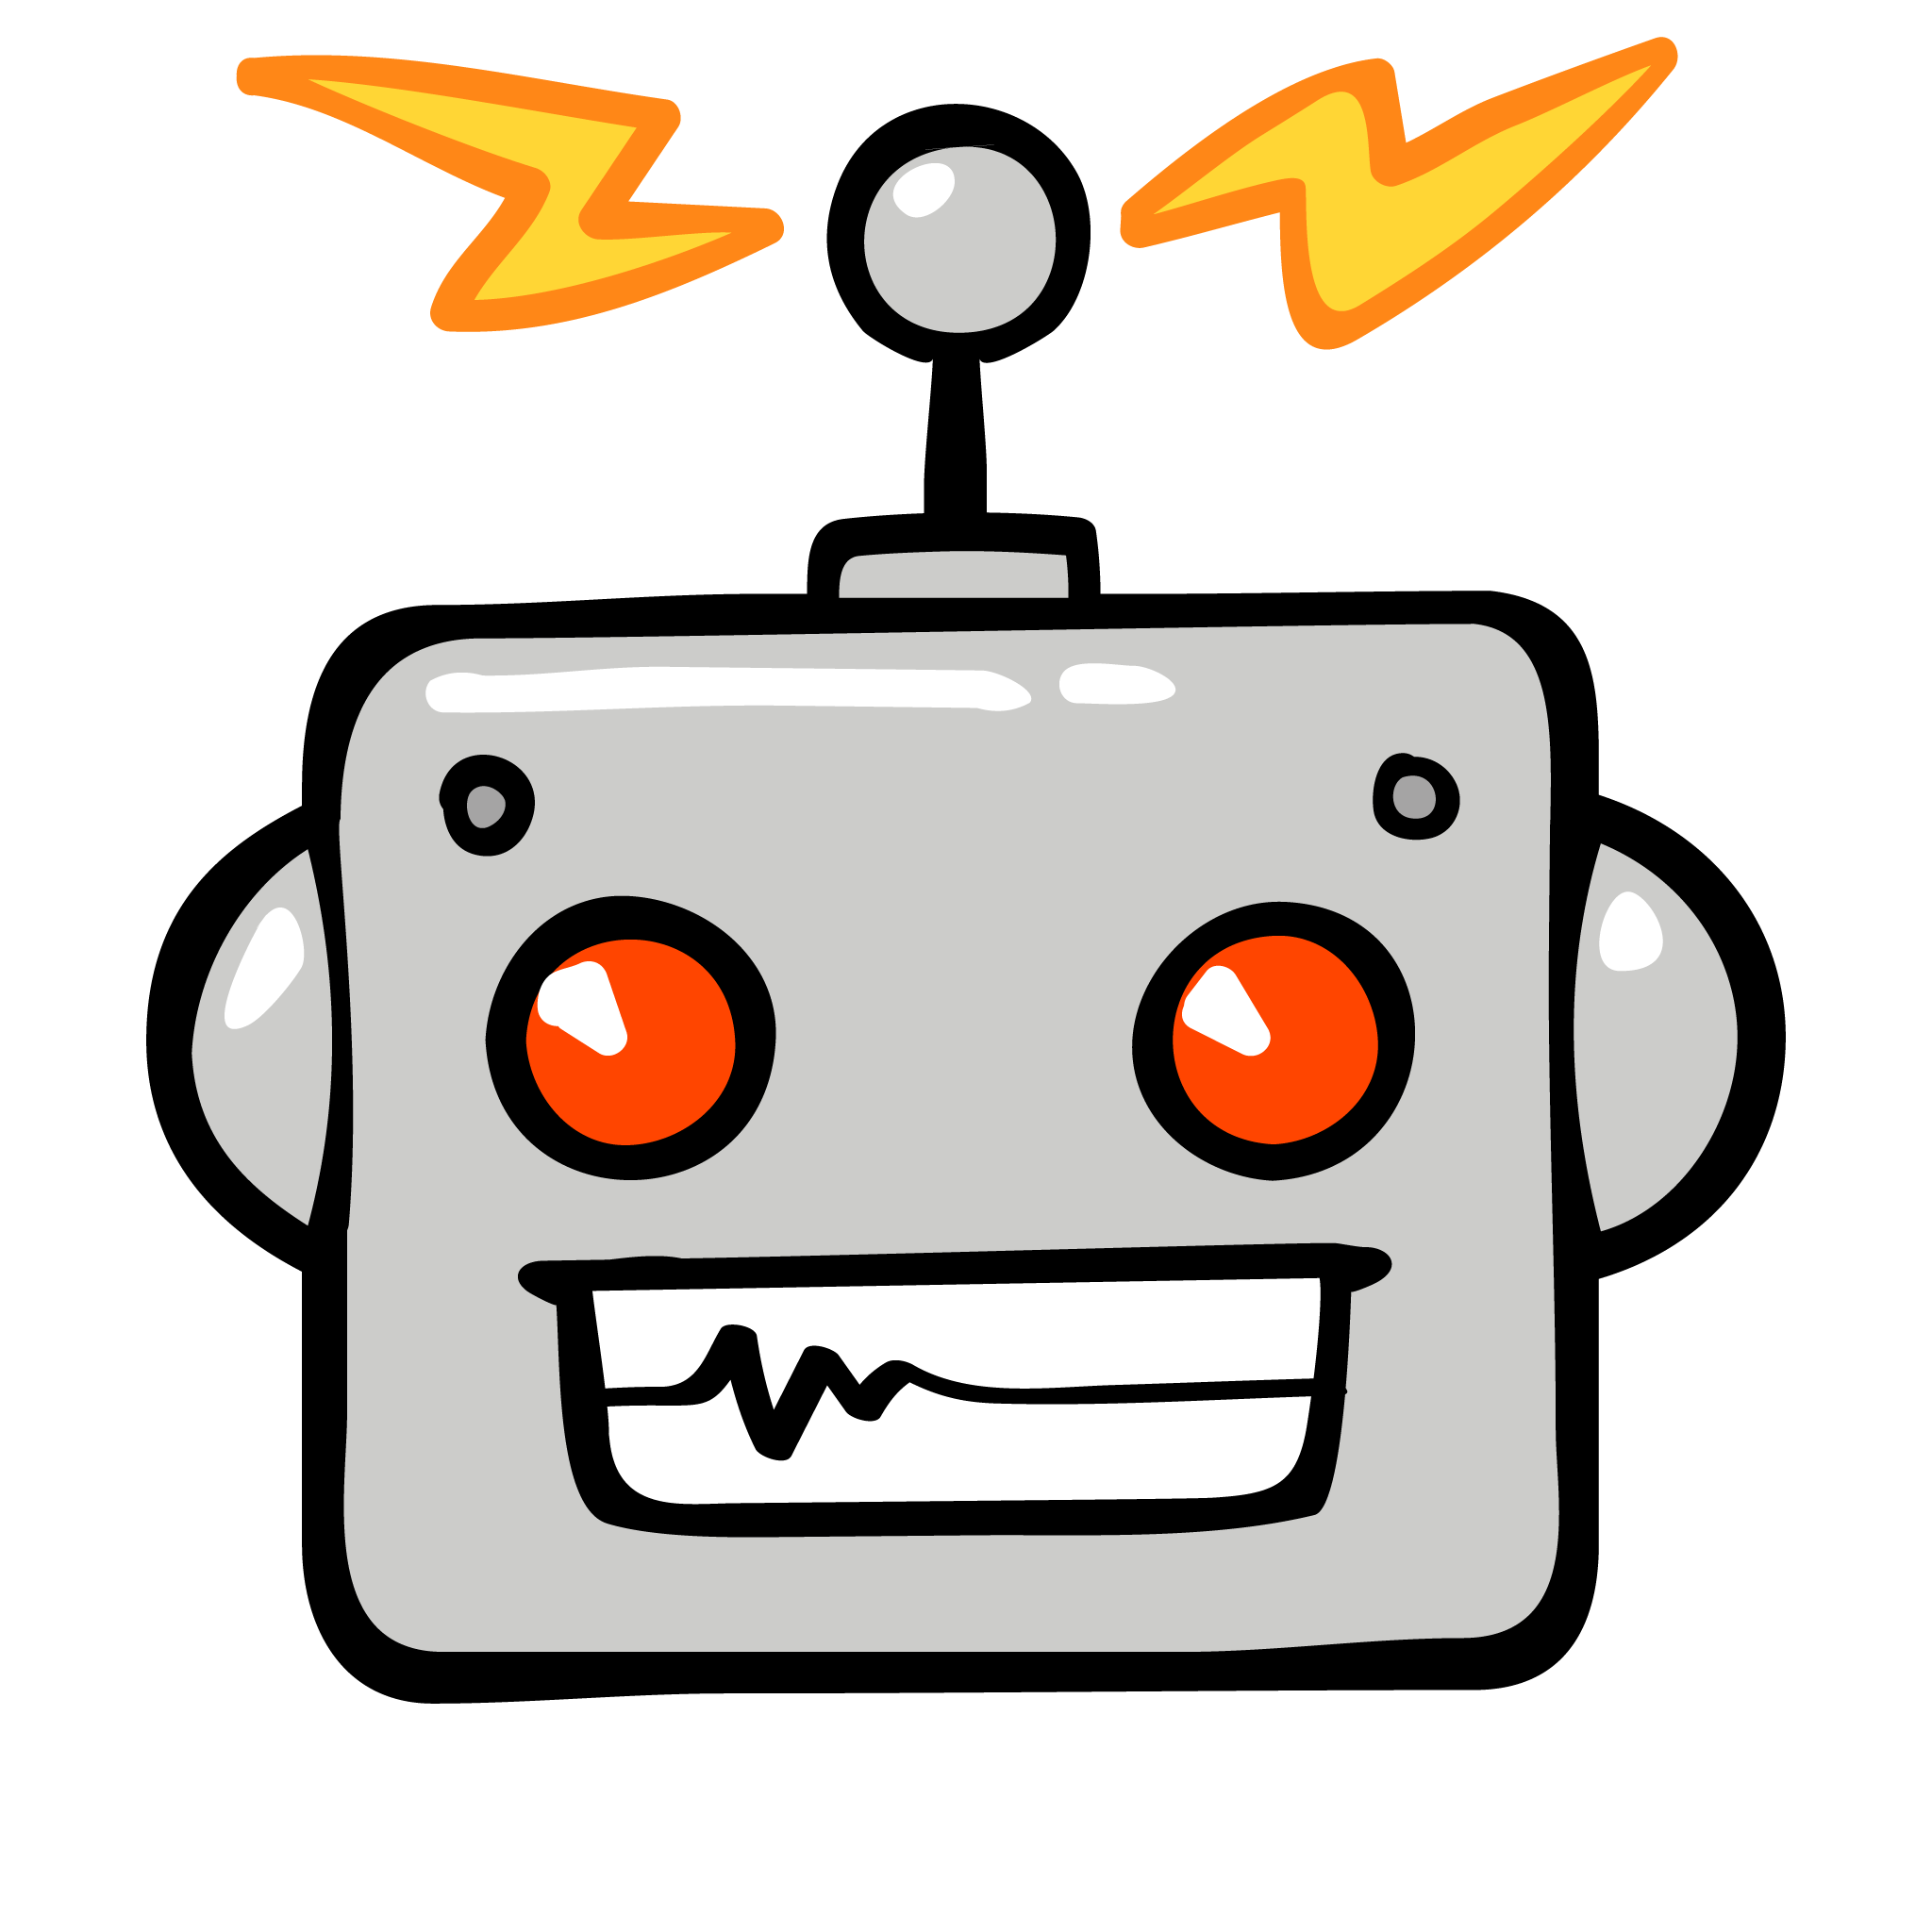

In [36]:
scrape_results

In [37]:
def text_parser(results):
    web_contents = {"contents": []}
    link_content = {}
    for result in results:
        soup = BeautifulSoup(result[2], 'html.parser')
        for element in soup(["script", "style", "img", "input"]):
            element.decompose()
        text = soup.get_text(separator="\n", strip=True)
        link_content["url"] = result[0]
        link_content["title"] = result[1]
        link_content["content"] = text[:2000]
        web_contents["contents"].append(link_content)
        link_content = {}
    return web_contents

In [38]:
text_parser(scrape_results)

{'contents': [{'url': 'https://learnwithhasan.com/blog/create-ai-agents-with-python/',
   'title': 'How To Create AI Agents With Python From Scratch (Full Guide) - LearnWithHasan',
   'content': 'How To Create AI Agents With Python From Scratch (Full Guide) - LearnWithHasan\nWe’ve paused new premium sign-ups to focus on our current members. Free accounts are still open — join the waiting list:\nClick Here\nLearn\nCommunity\nResources\nBlog\nForums\nGrowth Hacks\nNiche Database\nPrompts Library\nCodes Library\nNewsletter\nRoadmap\nTools I use\nMore\nToolerBox\nWPBuilder School\nSelfHost School\nSoloBuilder School\nExploding Startup\nSign in\nSign up\nSearch for:\nLearn\nCommunity\nBlog\nForums\nDomain Generator\nMicro-SaaS Ideas\nLog In\nShare on Facebook\nPost on X\nHow To Create AI Agents With Python From Scratch (Full Guide)\nHasan\nPower Member\nApril 30, 2024\n2\nComments\nIn this post, we will create an Autonomous AI Agent With Python from Scratch.\nWe will\nNOT\nuse any third-par

In [ ]:
# create new system prompt for the guide creation

guide_system_prompt = """
You are provided with a list of relevant search results in a form of url, title and content of the website.
The list will be provided in this format:

{
    "contents": [
        {"url": "https://full.url/here/", "title": "webpage title", "content": "content of the website"}, 
        {"url": "https://another.full.url/here/", "title": "webpage title", "content": "content of the website"}
    ]
}
You are able to create a brief study material for beginners for the topic you will be provided.

Please create a brief study material which will help beginners to start learning the topic. It is not a comprehensive material but
it should help students at the start of their journey and motivate them to continue and stay ont the track during the first days.
Please also give students useful tips how to stay motivated. 

"""

In [42]:
# create user prompt for the guide creation

query = {"topic": query}

def get_guide_prompt(resources):
    guide_user_prompt = f"""
    You are experienced tutor and creator of the various studying and teaching materials.

    Please create a brief study material which will help beginners to start learning the following topic:
    {query} 
    It is not a comprehensive material but it should help students at the start of their journey and motivate them to continue 
    and stay ont the track during the first days. Please also give students useful tips how to stay motivated.

    Here are the relevant resources you have available for the task:
    {text_parser(resources)} 
    """
    return guide_user_prompt


In [43]:
def get_guide():
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": guide_system_prompt},
            {"role": "user", "content": get_guide_prompt(scrape_results)}
        ]
    )
    result = response.choices[0].message.content
    return result


In [44]:
guide = get_guide()

In [47]:
#display(Markdown(guide))